In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(6667, 128, 128, 3)


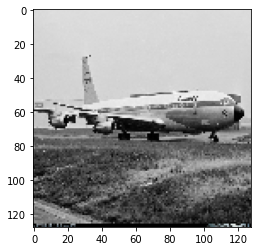

In [ ]:
with open('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/data/train_X.npy','rb') as f: 
  trainX = pickle.load(f)
  print(trainX.shape)
  plt.imshow(trainX[0])

In [ ]:
with open('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/data/train_Y.npy','rb') as f: 
  trainY = pickle.load(f)
  print(trainY.shape)
  print(trainY[0])

(6667,)
0


(3333, 128, 128, 3)


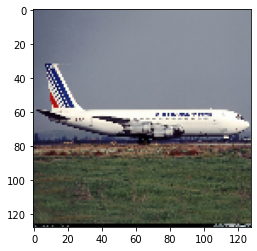

In [ ]:
with open('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/data/test_X.npy','rb') as f: 
  testX = pickle.load(f)
  print(testX.shape)
  plt.imshow(testX[0])

In [ ]:
with open('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/data/test_Y.npy','rb') as f: 
  testY = pickle.load(f)
  print(testY.shape)
  print(testY[0])

(3333,)
0


In [ ]:
learning_rate = 1e-4
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 12 # Size of the patches to be extract from the input images
num_patches = (image_size//patch_size)**2
projection_dim = 128
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(trainX)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding
        })
        return config


In [ ]:
def get_resnet50_layers(layer_names):
  net = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                input_shape=(72,72,3),
                                                weights='imagenet')
  net.trainable = True
  net.summary()
  
  outputs = [net.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([net.input], [outputs])
  
  return model

In [ ]:
# create the model:
content_layers = ['conv2_block1_out', 'conv2_block2_out', 'conv2_block3_out']

# get layers
content_extractor = get_resnet50_layers(content_layers)

x = tf.ones((1,72,72,3))
a = content_extractor(x)
for i in a[0]:
  print(i.shape)


94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 78, 78, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 36, 36, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 36, 36, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
input_shape = (128,128,3)
num_classes = 100
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    augmented2 = tf.keras.layers.Add()((content_extractor(augmented))[0])
    patches2 = Patches(3)(augmented2)
    # Encode patches.
    encoded_patches2 = PatchEncoder(num_patches, projection_dim)(patches2)
    encoded_patches = tf.keras.layers.Add()([encoded_patches, encoded_patches2])
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/Checkpoint/NEWPRO2.weights.{epoch:02d} - {val_loss:.2f}.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        verbose = 1
    )

    history = model.fit(
        x=trainX,
        y=trainY,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(testX, testY),
        callbacks=[checkpoint_callback],
    )

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             [[(None, 18, 18, 25  229760      ['data_augmentation[0][0]']      
                                6),                                                               
                                 (None, 18, 18, 256                                         

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/Checkpoint/NEWPRO2.weights.{epoch:02d} - {val_loss:.2f}.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        verbose = 1
    )

    history = model.fit(
        x=trainX,
        y=trainY,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(testX, testY),
        callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
vit_classifier.load_weights('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/Checkpoint/NEWPRO2.weights.42 - 3.30.h5')
history = run_experiment(vit_classifier)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_3[0][0]']                
                                                                                                  
 model (Functional)             [[(None, 18, 18, 25  229760      ['data_augmentation[1][0]']      
                                6),                                                               
                                 (None, 18, 18, 256                                         

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/Checkpoint/NEWPRO3.weights.{epoch:02d} - {val_loss:.2f}.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        verbose = 1
    )

    history = model.fit(
        x=trainX,
        y=trainY,
        batch_size=batch_size,
        epochs=50,
        validation_data=(testX, testY),
        callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
vit_classifier.load_weights('/content/drive/MyDrive/WorkingData/fgvc-aircraft-2013b/Checkpoint/NEWPRO2.weights.99 - 1.92.h5')
history = run_experiment(vit_classifier)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             [[(None, 18, 18, 25  229760      ['data_augmentation[0][0]']      
                                6),                                                               
                                 (None, 18, 18, 256                                         

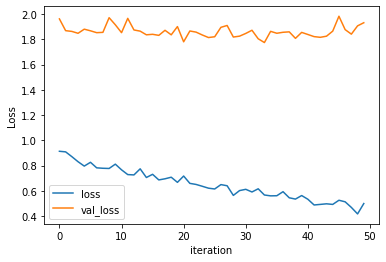

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

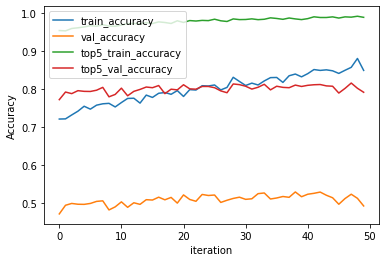

In [ ]:
import matplotlib.pyplot as plt

plt.plot( history.history['accuracy'], label='train_accuracy')
plt.plot( history.history['val_accuracy'], label='val_accuracy')
plt.plot( history.history['top-5-accuracy'], label='top5_train_accuracy')
plt.plot( history.history['val_top-5-accuracy'], label='top5_val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()